# Clustering

The data set which we worked on belongs to a French bakery. The dataset provides the daily transaction details of customers from 2021-01-01 to 2022-09-30. The dataset can be found at: https://www.kaggle.com/datasets/matthieugimbert/french-bakery-daily-sales.

We want to find clusters of transactions with regard to the time, day of week, month and items bought. For example, clients might buy baguettes at midday but croissants at 7 AM.

Importing the data from the CSV file.

In [1]:
import pandas as pd

DATA = pd.read_csv('Bakery sales.csv')
DATA.head()

,Unnamed: 0,date,time,ticket_number,article,Quantity,unit_price
0,0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,"0,90 €"
1,1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,"1,20 €"
2,4,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,"1,20 €"
3,5,2021-01-02,09:14,150041.0,PAIN,1.0,"1,15 €"
4,8,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,"1,20 €"


Cleaning the data and parsing the timestamps. The bakery opens at 7 AM so we converted all times of day to a number of minutes since 7 AM. We only kept transactions made in 2021 because it is the only year for which we have a full year of transactions.

In [60]:
DATA_CLEANED = DATA.loc[DATA['article'] != '.'].copy()
DATA_CLEANED['ticket_number'] = pd.to_numeric(DATA_CLEANED['ticket_number'], downcast='integer')
DATA_CLEANED['at'] = pd.to_datetime(DATA_CLEANED['date'] + ' ' + DATA_CLEANED['time'])
DATA_CLEANED = DATA_CLEANED[DATA_CLEANED['at'].dt.year == 2021]
DATA_CLEANED['month'] = DATA_CLEANED['at'].dt.month
DATA_CLEANED['day'] = DATA_CLEANED['at'].dt.weekday
DATA_CLEANED['minute'] = (DATA_CLEANED['at'].dt.hour - 7) * 60 + DATA_CLEANED['at'].dt.minute
DATA_CLEANED = DATA_CLEANED.drop(columns=['Unnamed: 0', 'Quantity', 'unit_price', 'date', 'time', 'at'])
DATA_CLEANED

,ticket_number,article,month,day,minute
0,150040,BAGUETTE,1,5,98
1,150040,PAIN AU CHOCOLAT,1,5,98
2,150041,PAIN AU CHOCOLAT,1,5,134
3,150041,PAIN,1,5,134
4,150042,TRADITIONAL BAGUETTE,1,5,145
...,...,...,...,...,...
131415,227277,BAGUETTE,12,4,656
131416,227277,FICELLE,12,4,656
131417,227278,BAGUETTE,12,4,659
131418,227278,PAIN,12,4,659


Get all items sold by the bakery.

In [61]:
ITEMS = DATA_CLEANED['article'].unique()
ITEMS

array(['BAGUETTE', 'PAIN AU CHOCOLAT', 'PAIN', 'TRADITIONAL BAGUETTE',
       'CROISSANT', 'BANETTE', 'BANETTINE', 'SPECIAL BREAD', 'COUPE',
       'SAND JB EMMENTAL', 'KOUIGN AMANN', 'BOULE 200G', 'BOULE 400G',
       'GAL FRANGIPANE 6P', 'CAMPAGNE', 'MOISSON', 'CAFE OU EAU',
       'BRIOCHE', 'CEREAL BAGUETTE', 'SEIGLE', 'COMPLET',
       'DIVERS PATISSERIE', 'GAL FRANGIPANE 4P', 'COOKIE', 'FICELLE',
       'PAIN AUX RAISINS', 'GAL POMME 6P', 'GAL POMME 4P', 'FINANCIER X5',
       'VIK BREAD', 'DIVERS VIENNOISERIE', 'GACHE', 'SANDWICH COMPLET',
       'PAIN BANETTE', 'GRAND FAR BRETON', 'QUIM BREAD',
       'SPECIAL BREAD KG', 'GD KOUIGN AMANN', 'BOULE POLKA',
       'DEMI BAGUETTE', 'CHAUSSON AUX POMMES', 'BAGUETTE GRAINE',
       'DIVERS CONFISERIE', 'SUCETTE', 'DIVERS BOULANGERIE',
       'BOISSON 33CL', 'PATES', 'FORMULE SANDWICH', 'DIVERS SANDWICHS',
       'CROISSANT AMANDES', 'PAIN CHOCO AMANDES', 'SACHET VIENNOISERIE',
       'NANTAIS', 'CHOCOLAT', 'PAIN S/SEL', 'FONDANT CHOC

In the initial dataset, each row corresponded to a single item sold. However, a customer transaction may contain several articles, so we grouped by ticket number (identifier for a given transaction) to obtain a list of items for each transaction. We are only keeping the `ticket_number`, the list of items and the time and date of purchase as we are not interested in the other attributes at the moment. 

In [62]:
TRANSACTIONS = DATA_CLEANED.groupby('ticket_number').agg({'article': list, 'month': 'first', 'day': 'first', 'minute': 'first'})
TRANSACTIONS.head()

,article,month,day,minute
ticket_number,,,,
150040,"[BAGUETTE, PAIN AU CHOCOLAT]",1,5,98
150041,"[PAIN AU CHOCOLAT, PAIN]",1,5,134
150042,[TRADITIONAL BAGUETTE],1,5,145
150043,"[BAGUETTE, CROISSANT]",1,5,145
150044,[BANETTE],1,5,147


How many transactions are we working with?

In [63]:
print(len(TRANSACTIONS))

76073


We now preprocess the data to easily compute distances between lists of items. To do that, we transform the `article` values into binary vectors of dimension the number of items sold in the bakery with 1s if the item is present in the transaction or 0s otherwise.

In [64]:
import numpy as np

def items_to_numeric(items: list[str]) -> list[int]:
    return np.array([1 if item in items else 0 for item in ITEMS])

TRANSACTIONS_WITH_NUMERIC_ITEMS = TRANSACTIONS.copy()
TRANSACTIONS_WITH_NUMERIC_ITEMS['article'] = TRANSACTIONS_WITH_NUMERIC_ITEMS['article'].apply(items_to_numeric)

TRANSACTIONS_WITH_NUMERIC_ITEMS


,article,month,day,minute
ticket_number,,,,
150040,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,5,98
150041,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,5,134
150042,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,5,145
150043,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,5,145
150044,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,5,147
...,...,...,...,...
227275,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",12,4,636
227276,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",12,4,641
227277,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",12,4,656


Now, we define the distance between two transactions. It is a weighted distance of:

* The distance between the transactions' days of week. We considered the day of week to be a categorical attribute so we used the dissimilarity measure from the course.
* The distance between the transactions' months defined as the smallest difference between the transactions' months squared. For example the distance between January and February is $1^2 = 1$ and the distance between January and December is $1^2$ as well.
* The distance between the transactions' time of day defined as the difference in minutes squared.
* The distance between items sold defined as 1 minus the cosine similarity between the two vectors we talked above.

We don't know the optimal weights yet, so we chose initial weights to balance the relative importance of each individual distance.

In [65]:
from matplotlib import pyplot as plt

def items_distance(a: np.array, b: np.array) -> float:
    return 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    
def mean_of_items(series: pd.Series):
    mean = [0] * len(ITEMS)
    for items in series:
        for i, item in enumerate(items):
            mean[i] += item
    for i in range(len(ITEMS)):
        mean[i] /= len(series)
    return mean

def month_distance(a: int, b: int) -> float:
    return min(abs(a - b), 12 - abs(a - b)) ** 2

def day_distance(a: int, b: int, cluster_size: int, count_of_transactions_with_day: int) -> float:
    if a == b:
        return 1 - count_of_transactions_with_day / cluster_size
    return 1

def distance(a, b, cluster_size: int, count_of_transactions_with_day: int, weight_month: float, weight_minute: float, weight_day: float, weight_article: float) -> float:
    return month_distance(a.month, b.month) * weight_month + \
        (b.minute - a.minute) ** 2 * weight_minute + \
        day_distance(a.day, b.day, cluster_size, count_of_transactions_with_day) * weight_day + \
        items_distance(a.article, b.article) * weight_article


Implement K-Prototype, using
* means for time and items, and
* mode for the months and days.

In [66]:
def k_prototype(transactions: pd.DataFrame, k: int, weight_month: float, weight_minute: float, weight_day: float, weight_article: float) -> dict:
    centers = transactions.sample(k).reset_index().drop(columns=['ticket_number']).copy().astype({
        'month': 'float',
        'day': 'float',
        'minute': 'float',
    })

    # Assign transactions uniformly to clusters.
    clusters = []
    count_of_transactions_per_cluster_per_day = [[0] * 7 for _ in range(k)]
    transactions_per_cluster = (len(transactions) + k - 1) // k
    for i, transaction in enumerate(transactions.itertuples()):
        cluster = i // transactions_per_cluster
        clusters.append(cluster)
        count_of_transactions_per_cluster_per_day[cluster][transaction.day] += 1

    last_sse = None
    sse = None
    
    while last_sse is None or sse < last_sse:
        last_sse = sse
        sse = 0

        for i, transaction in enumerate(transactions.itertuples()):
            min_d = None
            best_center = None

            for j, center in enumerate(centers.itertuples()):
                d = distance(transaction, center, len(transactions), count_of_transactions_per_cluster_per_day[j][transaction.day], weight_month, weight_minute, weight_day, weight_article)
                if min_d is None or d < min_d:
                    min_d = d
                    best_center = j
            
            sse += min_d * min_d
            clusters[i] = best_center

        # Add a cluster column to the transactions DataFrame.
        transactions_with_clusters = transactions.copy()
        transactions_with_clusters['cluster'] = clusters

        for i in range(k):
            transactions_in_cluster = transactions_with_clusters.loc[transactions_with_clusters['cluster'] == i]
            if len(transactions_in_cluster):
                index = centers.index[i]
                centers.loc[index, 'month'] = transactions_in_cluster['month'].mode()[0]
                centers.loc[index, 'day'] = transactions_in_cluster['day'].mode()[0]
                centers.loc[index, 'minute'] = transactions_in_cluster['minute'].mean()
                centers.loc[[index], 'article'] = pd.Series([mean_of_items(transactions_in_cluster['article'])], index=[index])
        
        # Update count_of_transactions_per_cluster_per_day.
        count_of_transactions_per_cluster_per_day = [[0] * 7 for _ in range(k)]
        for transaction in transactions_with_clusters.itertuples():
            count_of_transactions_per_cluster_per_day[transaction.cluster][transaction.day] += 1
    
    return centers, clusters, sse

Now, we find the best value of `k` using the Elbow method. 

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


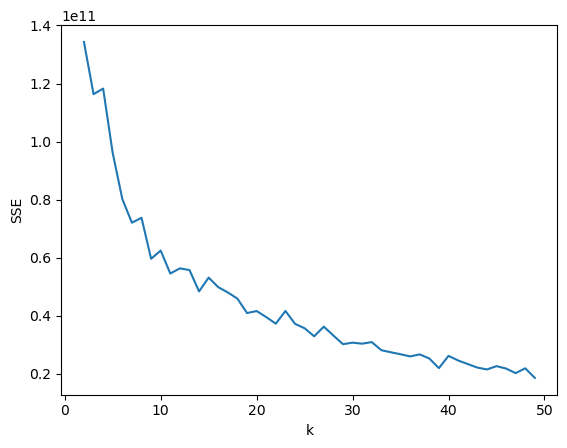

In [78]:
K = range(2, 50)
SSE = []

SAMPLES = TRANSACTIONS_WITH_NUMERIC_ITEMS.sample(1000)

for k in K:
    best_sse = None

    for _ in range(4):
        centers, clusters, sse = k_prototype(SAMPLES, k, 27.7, 0.0017, 1000, 20000)
        if best_sse is None or sse < best_sse:
            best_sse = sse
    
    SSE.append(best_sse)

plt.plot(K, SSE)
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow method')
plt.show()

Given the above results, we chose to take 16 as the number of clusters.

In [91]:
SAMPLES = TRANSACTIONS_WITH_NUMERIC_ITEMS
CENTERS, CLUSTERS, _sse = k_prototype(SAMPLES, 16, 27.7, 0.0017, 1000, 20000)

Below, we tried to visualize the clusters, but it was hard because it was hard due to the number of dimensions and transactions.

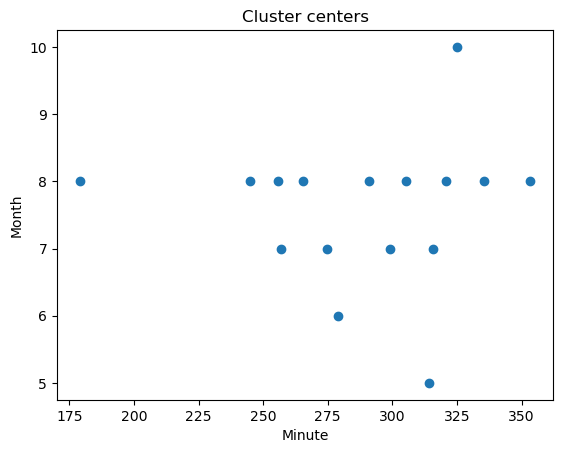

In [92]:
plt.scatter(CENTERS['minute'], CENTERS['month'])
plt.xlabel('Minute')
plt.ylabel('Month')
plt.title('Cluster centers')
plt.show()

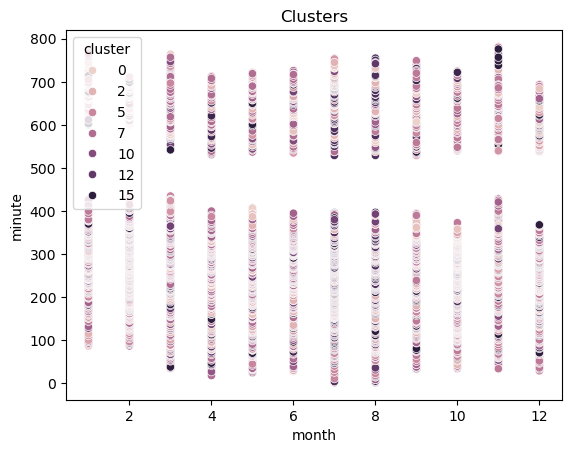

In [93]:
import seaborn as sns

TRANSACTIONS_WITH_CLUSTERS = SAMPLES.copy()
TRANSACTIONS_WITH_CLUSTERS['cluster'] = CLUSTERS

sns.scatterplot(data=TRANSACTIONS_WITH_CLUSTERS, x='month', y='minute', hue='cluster')
plt.title('Clusters')
plt.show()

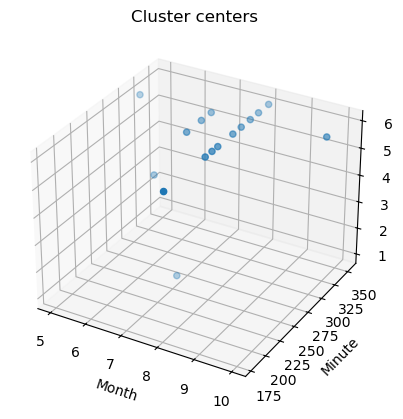

In [94]:
plot = plt.axes(projection='3d')
plot.scatter3D(CENTERS['month'], CENTERS['minute'], CENTERS['day'])
plot.set_xlabel('Month')
plot.set_ylabel('Minute')
plot.set_zlabel('Day')
plot.set_title('Cluster centers')

plt.show()

We apply to each cluster the pattern discovery of the other notebook to have a better idea of the cluster (difficult to visualize the data with plots). We print the month, day, and hour of the centroid of each cluster with the frequent patterns of the cluster.

In [95]:
import itertools
from typing import Iterable
import math

MINSUP = 0.3

def remove_infrequent_patterns(transactions: Iterable[frozenset[str]], patterns: list[frozenset[str]], threshold: int):
    counts = [0] * len(patterns)

    for transaction in transactions:
        for i, pattern in enumerate(patterns):
            if pattern.issubset(transaction):
                counts[i] += 1

    i = 0
    while i < len(patterns):
        if counts[i] < threshold:
            del patterns[i]
            del counts[i]
        else:
            i += 1

def get_candidates(F_k: list[frozenset[str]], k: int) -> set[frozenset[str]]:
    C_k_plus_1 = set()

    for i, p in enumerate(F_k):
        for q in F_k[i + 1:]:
            candidate = p.union(q)
            if len(candidate) != k + 1:
                continue
            all_subsets_of_candidate_are_frequent = True
            for subset in itertools.combinations(candidate, k):
                if set(subset) not in F_k:
                    all_subsets_of_candidate_are_frequent = False
                    break
            if not all_subsets_of_candidate_are_frequent:
                continue
            C_k_plus_1.add(candidate)

    return C_k_plus_1

def apriori(transactions: Iterable[frozenset[str]], items: frozenset[str], minsup: float) -> list[frozenset[str]]:
    threshold = minsup * len(transactions)

    # Start with singletons.
    F_1 = [frozenset([item]) for item in items]
    remove_infrequent_patterns(transactions, F_1, threshold)

    F = [F_1]

    for k in range(1, len(items)):
        C_k_plus_1 = get_candidates(F[-1], k)

        F_k_plus_1 = list(C_k_plus_1)
        remove_infrequent_patterns(transactions, F_k_plus_1, threshold)

        if not F_k_plus_1:
            break

        F.append(F_k_plus_1)

    return [pattern for F_k in F for pattern in F_k]

MONTHS = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
DAYS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i in range(len(CENTERS)):
    transactions_in_cluster = TRANSACTIONS_WITH_CLUSTERS.loc[TRANSACTIONS_WITH_CLUSTERS['cluster'] == i].copy()
    transactions_in_cluster['article'] = transactions_in_cluster['article'].apply(lambda x: frozenset(ITEMS[j] for j in range(len(x)) if x[j] == 1))
    items = frozenset(itertools.chain(*transactions_in_cluster['article']))
    frequent_patterns = apriori(transactions_in_cluster['article'], items, MINSUP)
    frequent_patterns.sort()

    month = MONTHS[math.floor(CENTERS['month'][i]) - 1]
    minute = math.floor(CENTERS['minute'][i])
    day = DAYS[math.floor(CENTERS['day'][i]) - 1]

    hour = str(7 + math.floor(CENTERS['minute'][i] // 60))
    minute = str(math.floor(CENTERS['minute'][i]) % 60).zfill(2)

    print(f'Patterns in cluster {i} ({day} {month} at {hour}:{minute}):')
    for pattern in frequent_patterns:
        print(', '.join(pattern))
    print()

Patterns in cluster 0 (Saturday August at 12:53):
TARTELETTE

Patterns in cluster 1 (Saturday August at 12:20):
CEREAL BAGUETTE

Patterns in cluster 2 (Saturday July at 11:34):
BANETTE

Patterns in cluster 3 (Saturday August at 11:04):
BANETTINE

Patterns in cluster 4 (Saturday July at 12:15):
SPECIAL BREAD
COUPE

Patterns in cluster 5 (Saturday August at 9:58):
CROISSANT
PAIN AU CHOCOLAT
TRADITIONAL BAGUETTE
CROISSANT, TRADITIONAL BAGUETTE
PAIN AU CHOCOLAT, CROISSANT

Patterns in cluster 6 (Saturday October at 12:25):
TRADITIONAL BAGUETTE

Patterns in cluster 7 (Saturday May at 12:14):
TRADITIONAL BAGUETTE

Patterns in cluster 8 (Monday July at 11:16):
PAIN AU CHOCOLAT

Patterns in cluster 9 (Saturday August at 12:35):
TRADITIONAL BAGUETTE
TARTELETTE
COOKIE
TARTELETTE, TRADITIONAL BAGUETTE

Patterns in cluster 10 (Saturday July at 11:59):
BOULE 200G
COUPE
BOULE 400G
COUPE, BOULE 400G
COUPE, BOULE 200G

Patterns in cluster 11 (Thursday June at 11:38):
FORMULE SANDWICH

Patterns in clus

We are happy about that clustering because it seems to distinguish between different kinds of transaction at a bakery: transactions for breakfast (CROISSANT, PAIN AU CHOCOLAT) with cluster 5, transactions for lunch with cluster 11 (SANDWICH), transactions for desserts with cluster 9, transactions for different breads on Saturday with cluster 10... 

We would have liked to have clusters for special events such as Épiphany with a lot of epiphany cake sold but we don't observe such clusters. We would also like for clusters 2 and 3 as well as 6 and 7 to be grouped as they seem very similar. Maybe with a different distance function it would have provided better results.